In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import initializers
import matplotlib.pyplot as plt
import numpy as np

2024-12-28 09:31:20.359200: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-28 09:31:20.629065: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1735378280.732236     726 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1735378280.762816     726 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-28 09:31:21.049738: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [2]:
(x_train, y_train), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()
print(x_train.shape[0], 'train samples')
print('image shape', x_train[0].shape)

60000 train samples
image shape (28, 28)


In [3]:
input_dim = 784
x_train = x_train.reshape(60000, input_dim)
print('input shape: ', x_train.shape[1])
x_train = (x_train.astype(np.float32) - 127.5) / 127.5

input shape:  784


In [4]:
optim = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)


I0000 00:00:1735378286.072523     726 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9517 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4070 SUPER, pci bus id: 0000:01:00.0, compute capability: 8.9


In [5]:
def build_discriminator():
    model =  keras.Sequential()
    model.add(layers.Dense(1024, input_dim=input_dim, kernel_initializer=initializers.RandomNormal(stddev=0.02)))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.3))

    model.add(layers.Dense(512))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.3))

    model.add(layers.Dense(256))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.3))

    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=optim)
    return model

In [6]:
latent_dim = 100

def build_generator():
    model =  keras.Sequential()
    model.add(layers.Dense(256, input_dim=latent_dim, kernel_initializer=initializers.RandomNormal(stddev=0.02)))
    model.add(layers.LeakyReLU(alpha=0.2))

    model.add(layers.Dense(512))
    model.add(layers.LeakyReLU(alpha=0.2))

    model.add(layers.Dense(1024))
    model.add(layers.LeakyReLU(alpha=0.2))

    model.add(layers.Dense(input_dim, activation='tanh'))
    model.compile(loss='binary_crossentropy', optimizer=optim)
    return model

In [7]:
discriminator = build_discriminator()
generator = build_generator()

# Combined network
discriminator.trainable = False
gan_input = keras.Input(shape=(latent_dim,))
x = generator(gan_input)
gan_output = discriminator(x)
gan = keras.Model(inputs=gan_input, outputs=gan_output)
gan.compile(loss='binary_crossentropy', optimizer=optim)

/home/user/.local/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/user/.local/lib/python3.12/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


In [8]:
def plot_generated_images(epoch, generator):
    num_of_images = 10
    noise = np.random.normal(0, 1, size=[num_of_images, latent_dim])
    generated_images=generator.predict(noise).reshape(num_of_images, 28, 28)
    plt.figure()
    for i in range(num_of_images):
        plt.subplot(1, 10, i+1)
        plt.imshow(generated_images[i], cmap = 'gray')
        plt.axis('off')
        plt.tight_layout()
    plt.show()

Epoch 0/20


2024-12-28 09:34:36.553409: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_203', 80 bytes spill stores, 80 bytes spill loads

2024-12-28 09:34:36.692578: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_203_0', 276 bytes spill stores, 276 bytes spill loads

2024-12-28 09:34:36.701176: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_203', 28 bytes spill stores, 28 bytes spill loads

2024-12-28 09:34:36.713472: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_203', 24 bytes spill stores, 24 bytes spill loads

2024-12-28 09:34:36.739864: I external/local_xla/xla/stream_

Discriminator loss: 0.5135, Generator loss: 1.6866
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


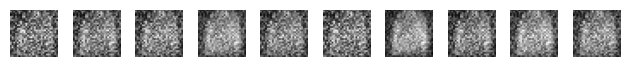

Epoch 1/20
Discriminator loss: 0.5108, Generator loss: 2.0491
Epoch 2/20
Discriminator loss: 0.5188, Generator loss: 1.9262
Epoch 3/20
Discriminator loss: 0.5260, Generator loss: 1.8639
Epoch 4/20
Discriminator loss: 0.5362, Generator loss: 1.7799
Epoch 5/20
Discriminator loss: 0.5469, Generator loss: 1.7044
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


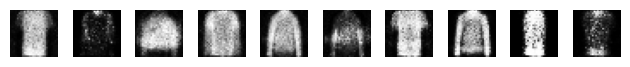

Epoch 6/20
Discriminator loss: 0.5586, Generator loss: 1.6335
Epoch 7/20
Discriminator loss: 0.5685, Generator loss: 1.5690
Epoch 8/20
Discriminator loss: 0.5778, Generator loss: 1.5167
Epoch 9/20
Discriminator loss: 0.5864, Generator loss: 1.4696
Epoch 10/20
Discriminator loss: 0.5942, Generator loss: 1.4303
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


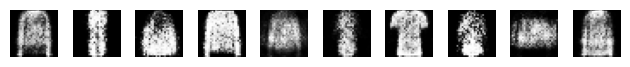

Epoch 11/20
Discriminator loss: 0.6008, Generator loss: 1.3983
Epoch 12/20
Discriminator loss: 0.6064, Generator loss: 1.3692
Epoch 13/20
Discriminator loss: 0.6114, Generator loss: 1.3454
Epoch 14/20
Discriminator loss: 0.6156, Generator loss: 1.3251
Epoch 15/20
Discriminator loss: 0.6192, Generator loss: 1.3076
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


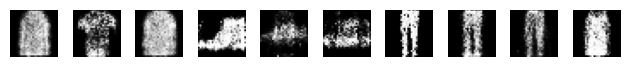

Epoch 16/20
Discriminator loss: 0.6223, Generator loss: 1.2916
Epoch 17/20
Discriminator loss: 0.6252, Generator loss: 1.2773
Epoch 18/20
Discriminator loss: 0.6278, Generator loss: 1.2651
Epoch 19/20
Discriminator loss: 0.6302, Generator loss: 1.2534
Epoch 20/20
Discriminator loss: 0.6324, Generator loss: 1.2429
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


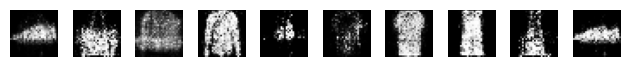

In [11]:
def train_model(epochs, batch_size):
    discrim_losses = []
    gen_losses = []

    discriminator.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    num_batches = int(x_train.shape[0] / batch_size)
    for ep in range(epochs + 1):
        print(f'Epoch {ep}/{epochs}')
        epoch_discrim_loss = 0
        epoch_gen_loss = 0

        for i in range(num_batches):
            noise = np.random.normal(0, 1, size=[batch_size, latent_dim])
            image_batch = x_train[np.random.randint(0, x_train.shape[0], size=batch_size)]

            generated_images = generator.predict(noise, verbose=0)
            X = np.concatenate([image_batch, generated_images])

            y_dis = np.zeros(2 * batch_size)
            y_dis[:batch_size] = 0.9

            discriminator.trainable = True
            d_loss = discriminator.train_on_batch(X, y_dis)[0]  # Extract only loss
            discrim_losses.append(d_loss)
            epoch_discrim_loss += d_loss

            noise = np.random.normal(0, 1, size=[batch_size, latent_dim])
            y_gen = np.ones(batch_size)
            discriminator.trainable = False
            g_loss = gan.train_on_batch(noise, y_gen)
            gen_losses.append(g_loss)
            epoch_gen_loss += g_loss

        print(f"Discriminator loss: {epoch_discrim_loss / num_batches:.4f}, Generator loss: {epoch_gen_loss / num_batches:.4f}")

        if ep % 5 == 0:
            plot_generated_images(ep, generator)

    return discrim_losses, gen_losses

epochs = 20
batch_size = 128
discrim_losses, gen_losses = train_model(epochs, batch_size)
